First, we scan over different values of noise and reservoir size. These kinds of arguments are generally called scaling laws. What we are interested in is not the quantitative values, but rather the qualitative change in the functional form of the reservoir performance. We've written a performant simulator, which is included as a .py file.

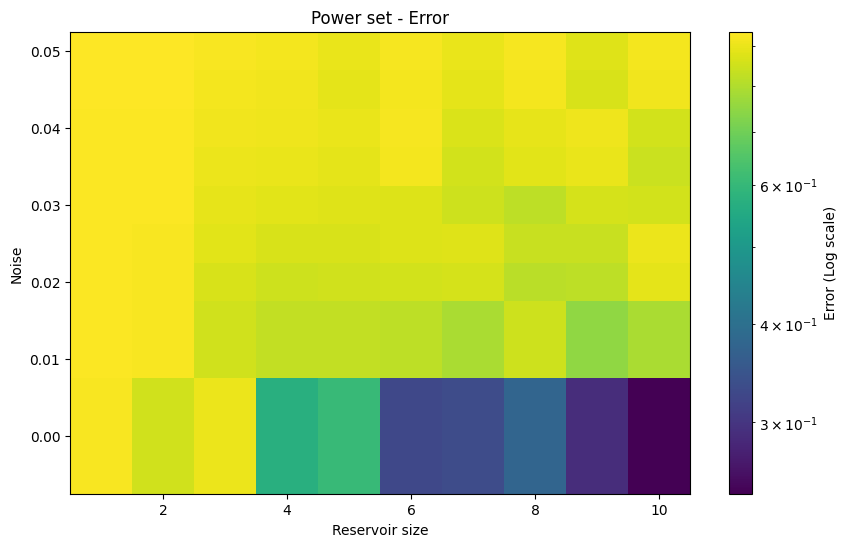

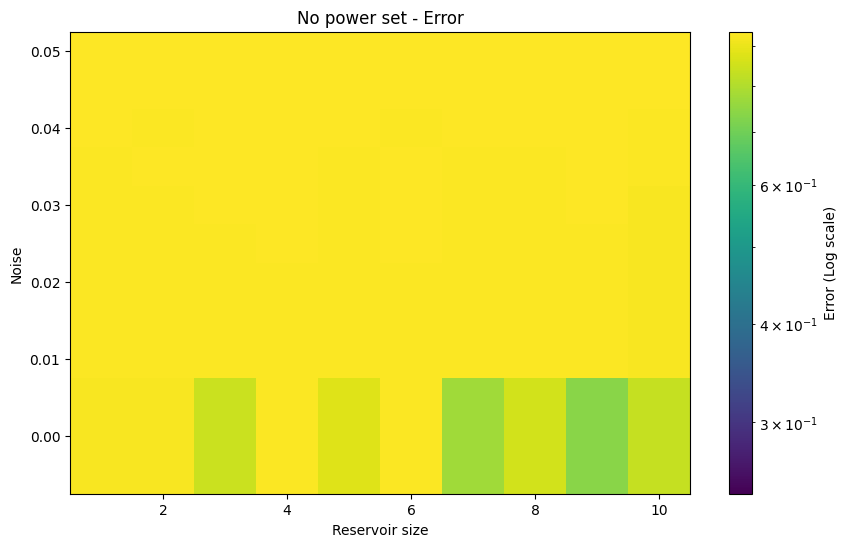

In [92]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import pickle as pkl

def get_best_per_size(data):
    sizes = np.unique(data[:, 1])
    best_values = {}
    for size in sizes:
        size_data = data[data[:, 1] == size]
        best_value = np.min(size_data[:, 0])
        best_values[size] = best_value
    return best_values

# list of all noise values
noise_values = [0.05, 0.045, 0.04, 0.035, 0.03, 0.025, 0.02, 0.015, 0]
all_best_values = {}

# Load all data and find best values per size
for power_set_str in ['True', 'False']:
    for noise in noise_values:
        file_name = f'results{power_set_str}{noise}.pkl'
        with open(file_name, 'rb') as f:
            nrmse = pkl.load(f)
        data = np.array(nrmse)
        all_best_values[(power_set_str, noise)] = get_best_per_size(data)
        
keys = list(all_best_values[('False', noise_values[0])].keys())[:10]

# Get min and max error for color scale across both powerset true and false
min_error = min(min(all_best_values[(power_set_str, noise)].values()) for power_set_str in ['True', 'False'] for noise in noise_values)
max_error = max(max(all_best_values[(power_set_str, noise)].values()) for power_set_str in ['True', 'False'] for noise in noise_values)

# Define the normalizer
norm = colors.LogNorm(vmin=min_error, vmax=max_error)

for power_set_str in ['True', 'False']:
    plt.figure(figsize=(10, 6))
    X = np.array(keys)  # Reservoir sizes
    Y = np.array(noise_values)  # Noise values
    Z = np.array([[all_best_values[(power_set_str, noise)][size] for size in keys] for noise in noise_values])  # Errors
    plt.pcolormesh(X, Y, Z, norm=norm, shading='auto', cmap='viridis')
    plt.title(f"{'Power set' if power_set_str == 'True' else 'No power set'} - Error")
    plt.xlabel('Reservoir size')
    plt.ylabel('Noise')
    plt.colorbar(label='Error (Log scale)')
    plt.show()

The power set collection does better, at larger reservoir sizes, and less noise. We see that the reservoir performance rapidly improves with reservoir size and small noise, and sharply declines with noise. But how sharply? Let's look at the horizontal slices, to see the functional scaling with reservoir size.

[0.43998481 0.0395711  0.5       ]
[0.43918221 0.04814156 0.5       ]
[0.44225201 0.0622405  0.5       ]
[0.44140244 0.07427661 0.5       ]
[0.44397453 0.10929036 0.5       ]
[0.43070057 0.08372422 0.5       ]
[0.43012819 0.10900983 0.5       ]
[0.44442515 0.19057742 0.5       ]


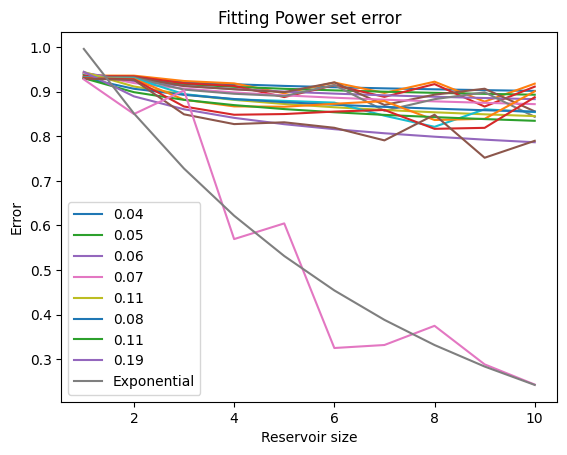

In [106]:
from scipy.optimize import curve_fit

Z = np.array([[all_best_values[('True', noise)][size] for size in keys] for noise in noise_values])  # Errors
        
# Define your function here
def inverse_poly(x, a, b, c):
    return a / (x ** b) + .5

def exponential(x, a, b):
    return a * np.exp(-b * x)

# For each signal in Z, estimate the parameters
inverse_poly_parms = []
for i in range(len(Z)-1):
    # Use the bounds keyword argument to set c >= 0
    p_opt, _ = curve_fit(inverse_poly, X, Z[i], maxfev=10000, bounds=([0, 0, 0], [1, 1, 1]))
    inverse_poly_parms.append(p_opt)
    print(p_opt)

# For the last signal in Z, estimate the parameters for the exponential 
exp_parms, _ = curve_fit(exponential, X, Z[-1])

# Now plot the functions using the estimated parameters
for i, parms in enumerate(inverse_poly_parms):
    plt.plot(X, inverse_poly(X, *parms), label=f'{round(parms[1], 2)}')
    plt.plot(X, Z[i])
plt.plot(X, Z[-1])
plt.plot(X, exponential(X, *exp_parms), label='Exponential')
#plt.plot(X, )
plt.title('Fitting Power set error')
plt.xlabel('Reservoir size')
plt.ylabel('Error')
plt.legend()
plt.show()

# We expect there the be an exponential reduction, so that the scaling law is polynomial, that is error $\sim a/n^b + c$. As noise goes to zero, $b\rightarrow \infty$, and $c\rightarrow 0$. For large enough noise, $c \rightarrow .5$, since the best the reservoir can do is randomly guess.